In [2]:
# Let's try in Python
import numpy as np

points = 100

# This function constructs the convection matrix for central difference
def construct_conv_matrix_central_diff(points):
    before = 1
    after = 1
    A = np.zeros(shape = (points, points+before+after))
    a = -0.5
    b = 0.
    c = 0.5

    for i in range(points):
        for j in range(points+before+after):
            if i + before == j:
                A[i,j] = b
                if j + 1 < points + before + after:
                    A[i,j+1] = c
                if j - 1 >= 0 :
                    A[i,j-1] = a
    return A

# This function constructs the convection matrix for 1st order upwind
def construct_conv_matrix_upwind(points):
    before = 1
    after = 1
    A = np.zeros(shape = (points, points + before + after))
    a = -1.
    b = 1.
    c = 0.

    for i in range(points):
        for j in range(points + before + after):
            if i + before == j:
                A[i,j] = b
                if j + 1 < points + before + after:
                    A[i,j+1] = c
                if j - 1 >= 0 :
                    A[i,j-1] = a
    return A

A = construct_conv_matrix_central_diff(points)
A_2 = construct_conv_matrix_upwind(points)

print(A)
print(A_2)

[[-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]]


In [3]:
# This function constructs the matrix for the 2nd derivative
def construct_diff_matrix_central_diff(points):
    before = 1
    after = 1
    B = np.zeros(shape = (points, points+before+after))
    a = 1.
    b = -2.
    c = 1.

    for i in range(points):
        for j in range(points+before+after):
            if i + before == j:
                B[i,j] = b
                if j + 1 < points+before+after:
                    B[i,j+1] = c
                if j - 1 >= 0 :
                    B[i,j-1] = a
    
    return B

B = construct_conv_matrix_central_diff(points)
print(B)
B.shape

[[-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.  -0.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]]


(100, 102)

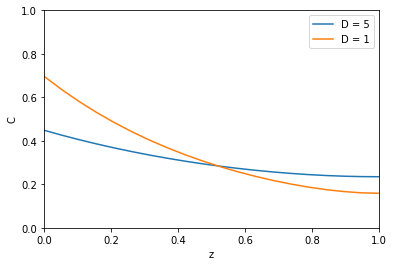

In [9]:
# we are going to use the solve function from the scipy.linalg package
from scipy.linalg import solve

y0 = 1.0

# avoid the fencepost error!
dx = 1./(points-1)
k = 10.
u = 4.
D = 5.

def construct_linear_matrix(u, D, k, y0, points, dx, method = 1):
    # method = 1: central difference
    # method = 2: 1st order upwind
    
    if method != 1:
        A = construct_conv_matrix_upwind(points)
    else:
        A = construct_conv_matrix_central_diff(points)
        
    B = construct_diff_matrix_central_diff(points)
    
    matrix = -u*A/dx + D*B/dx**2
    rates = np.eye(points + 2) * k
    rates[0,0] = 0.0
    rates[-1,-1] = 0.0
    first_row = np.zeros(shape = (points + 2))
    last_row = np.zeros(shape = (points + 2))
    
    if method != 1:
        first_row[0] = 1.
        first_row[1] = dx*u/D - 1.
    else:
        first_row[0] = 1.
        first_row[1] = 2.*dx*u/D
        first_row[2] = -1.
        
    last_row[-3] = -1.
    last_row[-1] = 1.
    matrix = np.vstack((first_row, matrix, last_row))
    matrix = matrix - rates
    # vector on the right hand side of the equation
    rhs = np.zeros(shape = (points + 2))
    
    if method != 1:
        rhs[0] = dx*u/D * y0
    else:
        rhs[0] = 2.*dx*u/D * y0
    
    return matrix, rhs

# Let's plot solutions for two different Ds
k = 10.
u = 4.
D = 5.
matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx)
C_lin = solve(matrix, rhs)
C_fin = C_lin[1:-1]

k = 10.
u = 4.
D = 1.
matrix, rhs = construct_linear_matrix(u, D, k, y0, points, dx)
C_lin = solve(matrix, rhs)
C_fin_1 = C_lin[1:-1]

# A small function to help plot the results
def plot_profiles(concs, points, legend):
    x = np.linspace(0, 1, num = points)
    for C in concs:
        plt.plot(x, C)
    plt.xlim((0., 1.0))
    plt.ylim((0., 1.0))
    plt.xlabel("z")
    plt.ylabel("C")
    plt.legend(legend)
    
plot_profiles([C_fin, C_fin_1], points, ["D = 5", "D = 1"])